# Univariate Gaussian with Constant Objective Function

In [1]:
import json

import numpy as np
import pandas as pd

from scipy.optimize import minimize

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style("darkgrid")

from src.callback import Simulator
from src.output import OutputGenerator

## Hyperparameters

In [2]:
# random number generation
random_state = 42
mu = 3
var = 2
sample_size = 500

# optimisation
initial_guess = -4
method = "Nelder-Mead"

## Generating a sample

The probability density function of the univariate Gaussian is given by:

$$f(x | \mu, \sigma^{2}) = \frac{1}{\sqrt{2\pi \sigma^{2}}}e^{-\frac{1}{2\sigma^{2}}(x - \mu)^{2}}$$

In [3]:
# set the random seed
rng = np.random.default_rng(random_state)

# generate a random sample using the numpy function
sample = rng.normal(mu, var, sample_size)

[-4.   -3.99 -3.98 ...  9.97  9.98  9.99]
Shape: (500,)


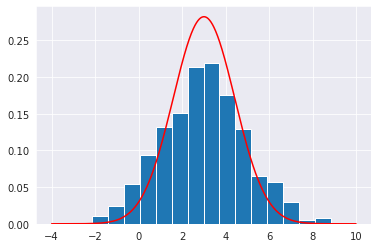

In [4]:
def pdf(x, mu, var):
    """
        Return a vector (shape of x) of the probabilities
        of the values of x
    """
    return 1 / (np.sqrt(2*np.pi*var)) * np.exp(-1/(2*var)*(x - mu)**2)

xx = np.arange(-4, 10, 0.01)

print(xx)
probs = pdf(xx, mu, var)

print(f"Shape: {sample.shape}")

plt.hist(sample, bins=15, density=True);
plt.plot(xx, probs, c='red')

## Maximum Likelihood Estimation

Here we minimise the likelihood function for the univariate Gaussian pdf. This allows us to find the best-fitting parameters.

The log-likelihood of the univariate Gaussian is given by:

$$\log \mathcal{L}(\mu, \sigma^{2}| \vec{x}) = -\frac{n}{2} \log (2\pi) - \frac{n}{2} \log \sigma^{2} - \frac{1}{2\sigma^{2}}\sum_{i = 1}^{n} (x_{i} - \mu)^{2}$$

and hence we want to minimise

$$\hat{\mu} = -\text{argmin}_{\mu} \log \mathcal{L}(\mu, \sigma^{2} | \vec{x})$$

## Defining the model

Here we define a model function which outputs a constant.

In [5]:
def const_model(params, x):
    # model paramater is constant
    return params

In [6]:
# define the univariate Gaussian likelihood function
def likelihood(params, x):
    mu = const_model(params, x)
    sigma = 2
    n = len(x)
    L = (n/2)*np.log(2*np.pi)+(n/2)*np.log(sigma**2)+(1/(2*sigma**2))*sum((x-mu)**2)
    return L

## Evaluating the likelihood function

Evaluating the likelihood function over a range of values, we can geometrically approximate the MLE to be zero.

Text(0.5, 0, 'Mean value: $\\mu$')

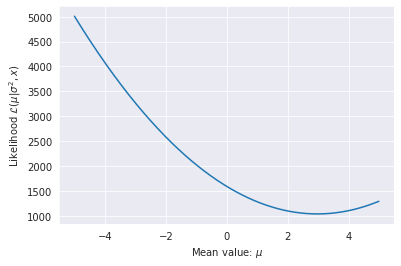

In [7]:
# range of mu values to test for maximum likelihood
mu_values = np.arange(-5, 5, 0.01)
# list for storing the likelihood values for each mu value
likelihood_values = []

# loop through all values of mu and append the likelihood value output to likelihood_values
for val in mu_values:
    likelihood_values.append(likelihood(val, sample))
     
# plot the likelihood values
plt.plot(mu_values, likelihood_values)
plt.ylabel("Likelihood $\mathcal{L}(\mu | \sigma^{2}, x)$")
plt.xlabel("Mean value: $\mu$")

## Minimising the likelihood function using scipy.optimize.minimize

Choose -4 as our initial guess for $\mu$.

As we can see in the plot above, $\text{MLE}_{\mu} \approx 3$, so we should see a clear path from left to right across the curve.

In [8]:
# instantiate the simulator class
lik_sim = Simulator(likelihood)

# minimise the -log(L) function using the wrapper class Simulator
lik_model = minimize(lik_sim.simulate, x0=initial_guess,
                     args=(sample),
                     method=method,
                     tol=1e-6,
                     options={"disp": True})

lik_model.x

Optimization terminated successfully.
         Current function value: 1035.950498
         Iterations: 27
         Function evaluations: 54


array([2.97374802])

In [9]:
callback = lik_sim.to_dataframe()

with pd.option_context('display.max_rows',10):
    print(callback)

    parameter   likelihood  iteration
0   -4.000000  4075.522809          1
1   -3.800000  3903.679117          2
2   -3.600000  3736.835424          3
3   -3.200000  3418.148039          4
4   -2.800000  3119.460654          5
..        ...          ...        ...
17   2.973755  1035.950498         18
18   2.973743  1035.950498         19
19   2.973749  1035.950498         20
20   2.973747  1035.950498         21
21   2.973748  1035.950498         22

[22 rows x 3 columns]


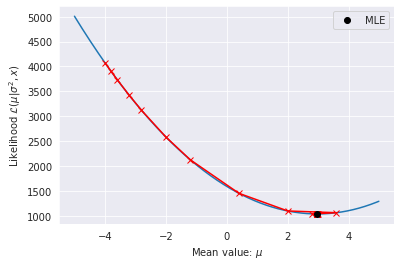

In [10]:
mu = np.arange(-5, 5, 0.01)
likelihood_values = []

for val in mu:
    likelihood_values.append(likelihood(val, sample))
     
plt.plot(mu, likelihood_values)
plt.plot(callback.parameter, callback.likelihood, 'r')
plt.plot(callback.parameter, callback.likelihood, 'rx')
plt.plot(lik_model.x, lik_model.fun, 'ko', label='MLE')

plt.ylabel("Likelihood $\mathcal{L}(\mu | \sigma^{2}, x)$")
plt.xlabel("Mean value: $\mu$")
plt.legend()

In [11]:
og = OutputGenerator(const_model, callback)

print(json.dumps(og.return_json(), sort_keys=True, indent=4))

{
    "meta_data": {
        "date": "09:18:35 19/07/2022",
        "method": "Nelder-Mead",
        "number_of_iterations": 22,
        "objective_function": "params"
    },
    "results": "{\"parameter\":{\"0\":-4.0,\"1\":-3.8,\"2\":-3.6,\"3\":-3.2,\"4\":-2.8,\"5\":-2.0,\"6\":-1.2,\"7\":0.4,\"8\":2.0,\"9\":3.6,\"10\":2.8,\"11\":3.0,\"12\":2.95,\"13\":2.975,\"14\":2.9734375,\"15\":2.973828125,\"16\":2.9737304688,\"17\":2.9737548828,\"18\":2.9737426758,\"19\":2.9737487793,\"20\":2.9737472534,\"21\":2.9737480164},\"likelihood\":{\"0\":4075.5228091062,\"1\":3903.6791166296,\"2\":3736.8354241529,\"3\":3418.1480391996,\"4\":3119.4606542463,\"5\":2582.0858843397,\"6\":2124.7111144331,\"7\":1449.9615746198,\"8\":1095.2120348066,\"9\":1060.4624949934,\"10\":1037.8372649,\"11\":1035.9935724233,\"12\":1035.9857455425,\"13\":1035.9505964829,\"14\":1035.9505044808,\"15\":1035.9504988711,\"16\":1035.9504984854,\"17\":1035.9504984701,\"18\":1035.9504984684,\"19\":1035.9504984669,\"20\":1035.9504984